In [1]:
import nest
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import elephant
import quantities as pq
import neo
import sys
from scipy.stats import ks_2samp
plt.rcParams['figure.figsize'] = (14, 10)
import scipy.stats as stats
import itertools
from elephant.conversion import BinnedSpikeTrain
from elephant.spike_train_correlation import correlation_coefficient

# If seaborn and elephant not available, run the sommands:
# !{sys.executable} -m pip install elephant
# !{sys.executable} -m pip install seaborn

# CC


In this file we will look at the CC of 10 different simulations in 5 different versions of brunel. We have the following models:

- Brunel with rounded spiketimes and discrete delays from interval [1.0, 2.0]
- Brunel with exact spiketimes and discrete delays from interval [1.0, 2.0]
- Brunel with rounded spiketimes and discrete delays from interval [0.9375, 2.0625]
- Brunel with exact spiketimes and discrete delays from interval [0.9375, 2.0625]
- Brunel with exact spiketimes and continuous delays from interval [1.0, 2.0]

Note that when the model uses discrete delays in interval [1.0, 2.0] the end points only have half the probability of getting drawn. When the discrete values are drawn from interval [0.9375, 2.0625], all points have equal probability of getting drawn. This because we use resolution 1/8. We use the continuous delay brunel model as the reference model, "true values". All simulations are run for 10s. Within one model, there are 10 simulations, each having a different seed value.

In this document we look at the distribution of the CCs for each simulation. We start by looking at the CC distribution for the 10 simulations in the same model. Run a Kolmogorov-Smirnov test on each possible pair of simulations, make sure that the KS-test gives us a pass, the CC distributions are supposed to be from the same distribution. Check that the p-values are uniformly distributed between 0 and 1. In that case there is not much difference.

Code for retrieving CC distribution of single simulation:

In [2]:
def get_ccs(spike_data, N=200, bs=2):
    """
    Get the CC between each possible pair of neurons, among the N first neurons. Default 200.
    Choose bin size bs, default 2, of how the spiketrains should be binned before calculating CC.
    
    CC = (x-mean(x))(y-mean(y))/sqrt((x-mean(x))^2(y-mean(y))^2)
    """
    # get all spike trains
    spike_data = spike_data.sort_values(by='time_ms')
    grouped = spike_data.groupby(spike_data['sender'])
    spike_trains = []
    for name, group in grouped:
        t = np.asarray(group['time_ms'])
        spiketrain = neo.core.SpikeTrain(t * pq.ms, t_start=0*pq.ms, t_stop=10000*pq.ms)
        spike_trains.append(spiketrain)
        
    # Only use first N spike trains 
    sp = [spike_trains[i] for i in range(0,N)]
    # calculate pearson correlation coefficient, stored in matrix
    corrcoef = correlation_coefficient(BinnedSpikeTrain(sp, bin_size=bs*pq.ms))
        
    # want to save in list, not matrix
    cor_list = []
    # start at 1 as values on diagonal are correlation 1 for element with itself
    for i in range(1,N):
        for j in range(0,i):
            cor_list.append(corrcoef[i,j])
    return cor_list

Function for retrieving cc distributions of excitatory and inhibitory population.

In [3]:
def get_cc_lists(exc, inh):
    cc_list_exc = list()
    for i in range(1,11):
        exc_ccs = get_ccs(exc[i])
        cc_list_exc.append(exc_ccs)

    cc_list_inh = list()
    for i in range(1,11):
        inh_ccs = get_ccs(inh[i])
        cc_list_inh.append(inh_ccs)
    return cc_list_exc, cc_list_inh

Functions for retrieving spike data from the 5 different brunel models.

In [4]:
def round_1_2():
    """
    Get spike data from brunel model with rounded spike times and delays drawn from discrete interval [1.0, 2.0].
    """
    spike_path = '/opt/data/spike_data/brunel_rounding_1_2'
    exc = {}
    for i in range(1,11):
        exc[i] = pd.read_csv(r'{}/brunel_rounding_True_delay_1.0_2.0_seed_{}_spikes_exc-12502-0.dat'.format(spike_path, i),
                             skiprows=2,sep='\t')

    inh = {}
    for i in range(1,11):
        inh[i] = pd.read_csv(r'{}/brunel_rounding_True_delay_1.0_2.0_seed_{}_spikes_inh-12503-0.dat'.format(spike_path, i),
                             skiprows=2,sep='\t')
    return exc, inh

In [5]:
def exact_1_2():
    """
    Get spike data from brunel model with exact spike times and delays drawn form discrete interval [1.0, 2.0].
    """
    spike_path = '/opt/data/spike_data/brunel_exact_1_2'
    exc = {}
    for i in range(1,11):
        exc[i] = pd.read_csv(r'{}/brunel_rounding_False_delay_1.0_2.0_seed_{}_spikes_exc-12502-0.dat'.format(spike_path, i),
                             skiprows=2,sep='\t')

    inh = {}
    for i in range(1,11):
        inh[i] = pd.read_csv(r'{}/brunel_rounding_False_delay_1.0_2.0_seed_{}_spikes_inh-12503-0.dat'.format(spike_path, i),
                             skiprows=2,sep='\t')
    return exc, inh

In [6]:
def round_equal():
    """
    Get spike data from brunel model with rounded spikes times and delay form interval [0.9375, 2.0625].
    """
    spike_path = '/opt/data/spike_data/brunel_rounding_0_9375_2_0625'
    exc = {}
    for i in range(1,11):
        exc[i] = pd.read_csv(r'{}/brunel_rounding_True_delay_0.9375_2.0625_seed_{}_spikes_exc-12502-0.dat'.format(spike_path, i),
                             skiprows=2,sep='\t')

    inh = {}
    for i in range(1,11):
        inh[i] = pd.read_csv(r'{}/brunel_rounding_True_delay_0.9375_2.0625_seed_{}_spikes_inh-12503-0.dat'.format(spike_path, i),
                             skiprows=2,sep='\t')
        
    return exc, inh

In [7]:
def exact_equal():
    """
    Get spike data from brunel with exact spike times and delays drawn from interval [0.9375, 2.0625].
    """
    
    spike_path = '/opt/data/spike_data/brunel_exact_0_9375_2_0625'
    exc = {}
    for i in range(1,11):
        exc[i] = pd.read_csv(r'{}/brunel_rounding_False_delay_0.9375_2.0625_seed_{}_spikes_exc-12502-0.dat'.format(spike_path, i),
                             skiprows=2,sep='\t')

    inh = {}
    for i in range(1,11):
        inh[i] = pd.read_csv(r'{}/brunel_rounding_False_delay_0.9375_2.0625_seed_{}_spikes_inh-12503-0.dat'.format(spike_path, i),
                             skiprows=2,sep='\t')
    
    return exc, inh

In [8]:
def continuous():
    """
    Get spike data from brunel model with delay drawn from continuous interval [1.0, 2.0].
    """
    spike_path = '/opt/data/spike_data/brunel_continuous'
    exc = {}
    for i in range(1,11):
        exc[i] = pd.read_csv(r'{}/brunel_continuous_delay_1.0_2.0_seed_{}_spikes_exc-12502-0.dat'.format(spike_path, i),
                             skiprows=2,sep='\t')

    inh = {}
    for i in range(1,11):
        inh[i] = pd.read_csv(r'{}/brunel_continuous_delay_1.0_2.0_seed_{}_spikes_inh-12503-0.dat'.format(spike_path, i),
                             skiprows=2,sep='\t')
    return exc, inh

Function for running KS-test on all possible pairs of simulations from the same model.

In [9]:
def ks_test(value_list):
    """
    Perform KS-test on all possible pairs of simulations from same model. (10 simulations). 
    Return statistic and p-values.
    """
    statistics = []
    p_values = []
    for i in range(0,10):
        for j in range(0,i):
            statistic = ks_2samp(value_list[i], value_list[j], alternative='two-sided')[0]
            p_value = ks_2samp(value_list[i], value_list[j], alternative='two-sided')[1]
            p_values.append(p_value)
            statistics.append(statistic)
    return statistics, p_values
        

Function for finding number of tests which passed and which failed.

In [10]:
def num_fail_pass(statistics, p_values):
    """
    Get number of tests which failed and which passed.
    """
    failed = 0
    passed = 0
    for i in range(0,len(statistics)):
        if statistics[i] > p_values[i]:
            # test fails
            failed += 1
        else:
            passed += 1
    s = str(passed) + ' tests passed, ' + str(failed) + ' tests failed.'
    return s

## Brunel with rounded spike times and discrete delays in interval [1.0, 2.0]

First we retrieve the spike data for all the simulations of both excitatory and inhibitory neurons:

In [11]:
exc, inh = round_1_2()

We now retrieve the CV distribution of each simualtion, for both excitatory and inhibitory neurons.

In [12]:
cc_list_exc, cc_list_inh = get_cc_lists(exc, inh)

/usr/local/lib/python3.8/dist-packages/elephant/conversion.py:1168: UserWarning:Binning discarded 4 last spike(s) of the input spiketrain
/usr/local/lib/python3.8/dist-packages/elephant/conversion.py:1168: UserWarning:Binning discarded 1 last spike(s) of the input spiketrain
/usr/local/lib/python3.8/dist-packages/elephant/conversion.py:1168: UserWarning:Binning discarded 2 last spike(s) of the input spiketrain


### Pair-wise KS-test on excitatory neurons CC distribution

The KS statistic gives the maximum value difference between two empirical cumulative distributions. So the smaller the statistic, the more similar is the distributions. The null hypothesis is that the two distributions are equal. The test accept the null-hypothesis if the statistic is smaller than the p-value.

We run a KS test on each possible pair of excitatory neurons CC distribution.

In [13]:
statistics, p_values = ks_test(cc_list_exc)
s = num_fail_pass(statistics, p_values)
print(s)

25 tests passed, 20 tests failed.


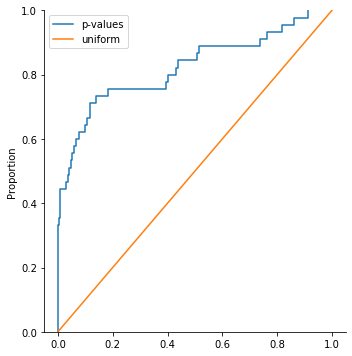

In [14]:
sns.displot(p_values,kind='ecdf',label='p-values')
plt.plot([0,1],[0,1],label='uniform')
plt.legend()
plt.show()



### Pair-wise KS-test on inhibitory neurons CV distribution

In [15]:
statistics, p_values = ks_test(cc_list_inh)
s = num_fail_pass(statistics, p_values)
print(s)

25 tests passed, 20 tests failed.


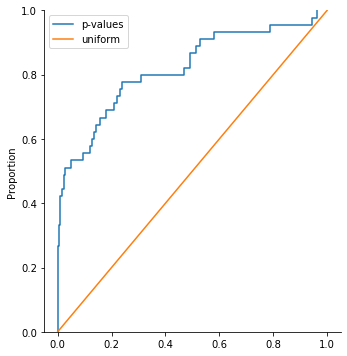

In [16]:
sns.displot(p_values,kind='ecdf',label='p-values')
plt.plot([0,1],[0,1],label='uniform')
plt.legend()
plt.show()

The inhibitory neurons seem to be more consistent as their p-values are closer to the uniform distribution.

## Brunel with exact spike times and discrete delays in interval [1.0, 2.0]

In [17]:
exc, inh = exact_1_2()
cc_list_exc, cc_list_inh = get_cc_lists(exc, inh)

### Pair-wise KS-test on excitatory neurons CV distribution

In [18]:
statistics, p_values = ks_test(cc_list_exc)
s = num_fail_pass(statistics, p_values)
print(s)

26 tests passed, 19 tests failed.


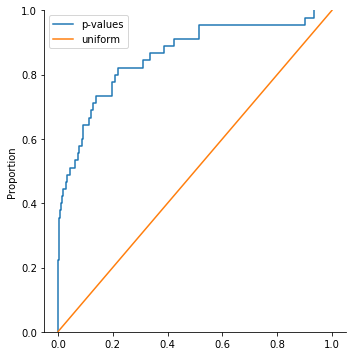

In [19]:
sns.displot(p_values,kind='ecdf',label='p-values')
plt.plot([0,1],[0,1],label='uniform')
plt.legend()
plt.show()

More consistent than excitatory neurons with rounded spike times on [1.0, 2.0].

### Pair-wise KS-test on inhibitory neurons CC distribution

In [20]:
statistics, p_values = ks_test(cc_list_inh)
s = num_fail_pass(statistics, p_values)
print(s)

21 tests passed, 24 tests failed.


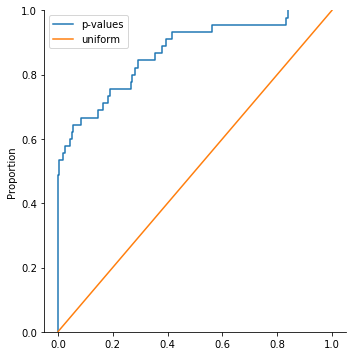

In [21]:
sns.displot(p_values,kind='ecdf',label='p-values')
plt.plot([0,1],[0,1],label='uniform')
plt.legend()
plt.show()

## Brunel with rounded spike times and discrete delays in interval [0.9375, 2.0625]

In [22]:
exc, inh = round_equal()
cc_list_exc, cc_list_inh = get_cc_lists(exc, inh)

/usr/local/lib/python3.8/dist-packages/elephant/conversion.py:1168: UserWarning:Binning discarded 1 last spike(s) of the input spiketrain
/usr/local/lib/python3.8/dist-packages/elephant/conversion.py:1168: UserWarning:Binning discarded 2 last spike(s) of the input spiketrain
/usr/local/lib/python3.8/dist-packages/elephant/conversion.py:1168: UserWarning:Binning discarded 3 last spike(s) of the input spiketrain
/usr/local/lib/python3.8/dist-packages/elephant/conversion.py:1168: UserWarning:Binning discarded 4 last spike(s) of the input spiketrain


### Pairwise KS-test on excitatory neurons

In [23]:
statistics, p_values = ks_test(cc_list_exc)
s = num_fail_pass(statistics, p_values)
print(s)

28 tests passed, 17 tests failed.


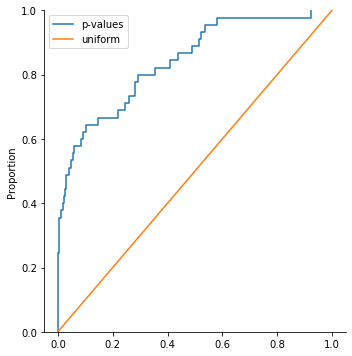

In [24]:
sns.displot(p_values,kind='ecdf',label='p-values')
plt.plot([0,1],[0,1],label='uniform')
plt.legend()
plt.show()

### Pairwise KS-test on inhibitory neurons

In [25]:
statistics, p_values = ks_test(cc_list_inh)
s = num_fail_pass(statistics, p_values)
print(s)

29 tests passed, 16 tests failed.


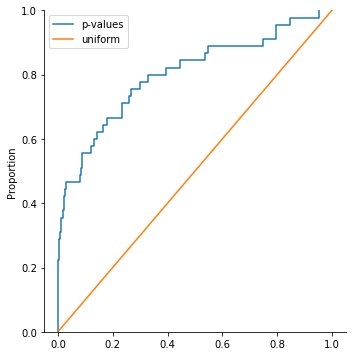

In [26]:
sns.displot(p_values,kind='ecdf',label='p-values')
plt.plot([0,1],[0,1],label='uniform')
plt.legend()
plt.show()

## Brunel with exact spike times and discrete delays in interval [0.9375, 2.0625]

In [27]:
exc, inh = exact_equal()
cc_list_exc, cc_list_inh = get_cc_lists(exc, inh)

### Pairwise KS-test on excitatory neurons

In [28]:
statistics, p_values = ks_test(cc_list_exc)
s = num_fail_pass(statistics, p_values)
print(s)

26 tests passed, 19 tests failed.


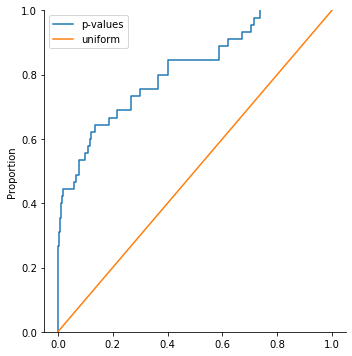

In [29]:
sns.displot(p_values,kind='ecdf',label='p-values')
plt.plot([0,1],[0,1],label='uniform')
plt.legend()
plt.show()

### Pairwise KS-test on inhibitory neurons

In [30]:
statistics, p_values = ks_test(cc_list_inh)
s = num_fail_pass(statistics, p_values)
print(s)

31 tests passed, 14 tests failed.


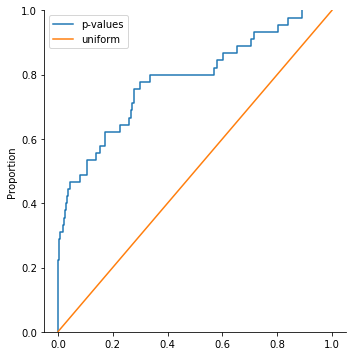

In [31]:
sns.displot(p_values,kind='ecdf',label='p-values')
plt.plot([0,1],[0,1],label='uniform')
plt.legend()
plt.show()

## Brunel with continuous delays [1.0, 2.0]

In [32]:
exc, inh = continuous()
cc_list_exc, cc_list_inh = get_cc_lists(exc, inh)

### Pairwise KS-test on excitatory neurons

In [33]:
statistics, p_values = ks_test(cc_list_exc)
s = num_fail_pass(statistics, p_values)
print(s)

30 tests passed, 15 tests failed.


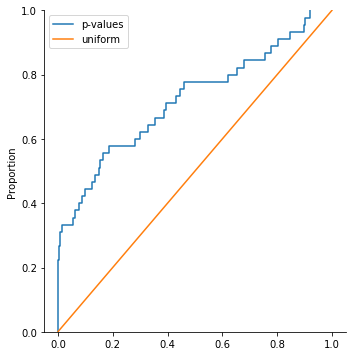

In [34]:
sns.displot(p_values,kind='ecdf',label='p-values')
plt.plot([0,1],[0,1],label='uniform')
plt.legend()
plt.show()

### Pairwise KS-test on inhibitory neurons

In [35]:
statistics, p_values = ks_test(cc_list_inh)
s = num_fail_pass(statistics, p_values)
print(s)

29 tests passed, 16 tests failed.


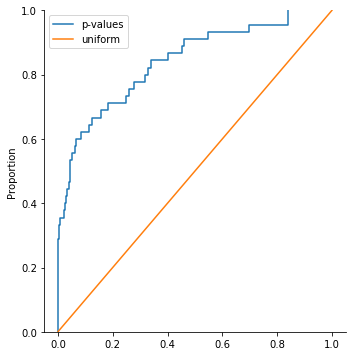

In [36]:
sns.displot(p_values,kind='ecdf',label='p-values')
plt.plot([0,1],[0,1],label='uniform')
plt.legend()
plt.show()

## Comparing models

We now start running the KS-tests on each possible pair of simulations from two different models. We want to get an overview over how similar the CC distribution is for two different models. All of the discrete cases should be compared  to the continuous case, but also against each other. We start with comparing the Brunel model with the rounded spike times and delays drawn from the discrete delay interval [1.0, 2.0].

In [37]:
def ks_test(value_list_1, value_list_2):
    """
    Perform KS-test on all possible compinations of pairwise simulations in two different models.
    """
    comb = list(itertools.product(value_list_1, value_list_2))

    statistics = []
    p_values = []
    for i in range(0,len(comb)):
        statistic = ks_2samp(comb[i][0],comb[i][1],alternative='two-sided')[0]
        p_value = ks_2samp(comb[i][0],comb[i][1],alternative='two-sided')[1]
        statistics.append(statistic)
        p_values.append(p_value)
    return statistics, p_values

### Rounded brunel on discrete [1.0, 2.0] vs. exact brunel on discrete [1.0, 2.0]

First we read in the data (make sure this part is independent of what was run earlier). 

In [38]:
exc_1, inh_1 = round_1_2()
exc_2, inh_2 = exact_1_2()

Get the CC distributions.

In [39]:
cc_list_exc_1, cc_list_inh_1 = get_cc_lists(exc_1, inh_1)
cc_list_exc_2, cc_list_inh_2 = get_cc_lists(exc_2, inh_2)

/usr/local/lib/python3.8/dist-packages/elephant/conversion.py:1168: UserWarning:Binning discarded 4 last spike(s) of the input spiketrain
/usr/local/lib/python3.8/dist-packages/elephant/conversion.py:1168: UserWarning:Binning discarded 1 last spike(s) of the input spiketrain
/usr/local/lib/python3.8/dist-packages/elephant/conversion.py:1168: UserWarning:Binning discarded 2 last spike(s) of the input spiketrain


In [40]:
statistics, p_values = ks_test(cc_list_exc_1, cc_list_exc_2)
s = num_fail_pass(statistics, p_values)
print(s)

0 tests passed, 100 tests failed.


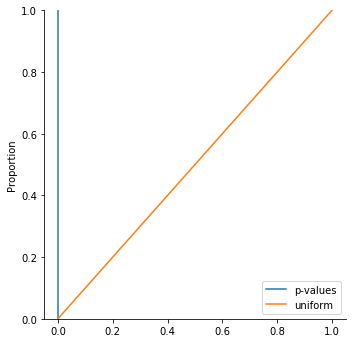

In [41]:
sns.displot(p_values,kind='ecdf',label='p-values')
plt.plot([0,1],[0,1],label='uniform')
plt.legend()
plt.show()

In [42]:
statistics, p_values = ks_test(cc_list_inh_1, cc_list_inh_2)
s = num_fail_pass(statistics, p_values)
print(s)

0 tests passed, 100 tests failed.


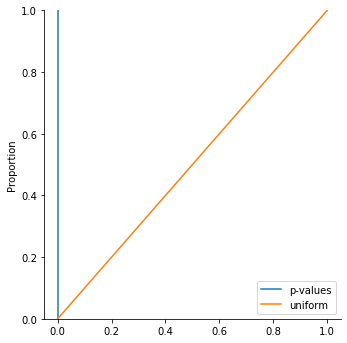

In [43]:
sns.displot(p_values,kind='ecdf',label='p-values')
plt.plot([0,1],[0,1],label='uniform')
plt.legend()
plt.show()

### Rounded brunel on [1.0, 2.0] vs. rounded brunel on [0.9375, 2.0625]

Get the data for the second model.

In [44]:
exc_2, inh_2 = round_equal()
cc_list_exc_2, cc_list_inh_2 = get_cc_lists(exc_2, inh_2)

/usr/local/lib/python3.8/dist-packages/elephant/conversion.py:1168: UserWarning:Binning discarded 1 last spike(s) of the input spiketrain
/usr/local/lib/python3.8/dist-packages/elephant/conversion.py:1168: UserWarning:Binning discarded 2 last spike(s) of the input spiketrain
/usr/local/lib/python3.8/dist-packages/elephant/conversion.py:1168: UserWarning:Binning discarded 3 last spike(s) of the input spiketrain
/usr/local/lib/python3.8/dist-packages/elephant/conversion.py:1168: UserWarning:Binning discarded 4 last spike(s) of the input spiketrain


In [45]:
statistics, p_values = ks_test(cc_list_exc_1, cc_list_exc_2)
s = num_fail_pass(statistics, p_values)
print(s)

59 tests passed, 41 tests failed.


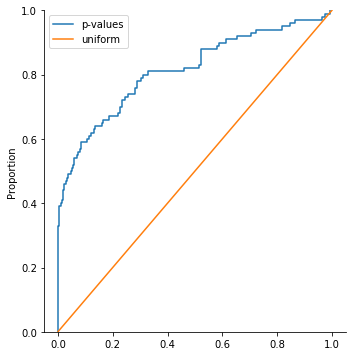

In [46]:
sns.displot(p_values,kind='ecdf',label='p-values')
plt.plot([0,1],[0,1],label='uniform')
plt.legend()
plt.show()

In [47]:
statistics, p_values = ks_test(cc_list_inh_1, cc_list_inh_2)
s = num_fail_pass(statistics, p_values)
print(s)

65 tests passed, 35 tests failed.


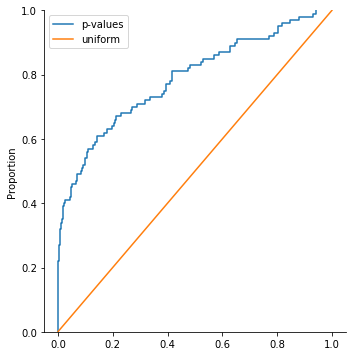

In [48]:
sns.displot(p_values,kind='ecdf',label='p-values')
plt.plot([0,1],[0,1],label='uniform')
plt.legend()
plt.show()

### Rounded Brunel on [1.0, 2.0] vs. exact brunel on [0.9375, 2.0625]

Get data of second model.

In [49]:
exc_2, inh_2 = exact_equal()
cc_list_exc_2, cc_list_inh_2 = get_cc_lists(exc_2, inh_2)

In [50]:
statistics, p_values = ks_test(cc_list_exc_1, cc_list_exc_2)
s = num_fail_pass(statistics, p_values)
print(s)

0 tests passed, 100 tests failed.


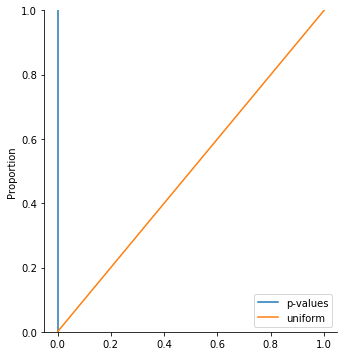

In [51]:
sns.displot(p_values,kind='ecdf',label='p-values')
plt.plot([0,1],[0,1],label='uniform')
plt.legend()
plt.show()

In [53]:
statistics, p_values = ks_test(cc_list_inh_1, cc_list_inh_2)
s = num_fail_pass(statistics, p_values)
print(s)

0 tests passed, 100 tests failed.


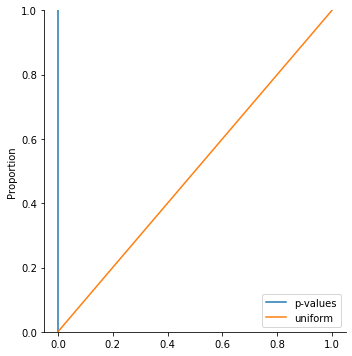

In [54]:
sns.displot(p_values,kind='ecdf',label='p-values')
plt.plot([0,1],[0,1],label='uniform')
plt.legend()
plt.show()

### Rounded Brunel on [1.0, 2.0] vs. continuous brunel on [1.0, 2.0]
Get data of second model first.

In [55]:
exc_2, inh_2 = continuous()
cc_list_exc_2, cc_list_inh_2 = get_cc_lists(exc_2, inh_2)

In [56]:
statistics, p_values = ks_test(cc_list_exc_1, cc_list_exc_2)
s = num_fail_pass(statistics, p_values)
print(s)

0 tests passed, 100 tests failed.


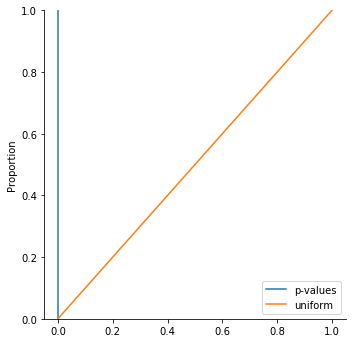

In [57]:
sns.displot(p_values,kind='ecdf',label='p-values')
plt.plot([0,1],[0,1],label='uniform')
plt.legend()
plt.show()

In [58]:
statistics, p_values = ks_test(cc_list_inh_1, cc_list_inh_2)
s = num_fail_pass(statistics, p_values)
print(s)

0 tests passed, 100 tests failed.


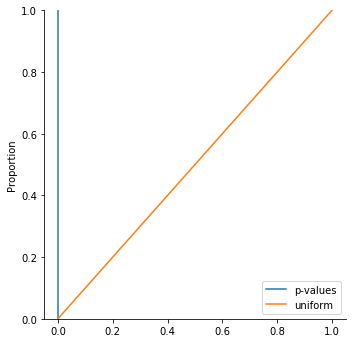

In [59]:
sns.displot(p_values,kind='ecdf',label='p-values')
plt.plot([0,1],[0,1],label='uniform')
plt.legend()
plt.show()

### Exact brunel on [1.0,2.0] vs. rounded brunel on [0.9375, 2.0625]

Now we can look into the Brunel model with exact spike times and delays from discrete interval [1.0, 2.0]. We have already compared it with the rounded case on the same interval, so skip this one. 

Get the data first.

In [60]:
exc_1, inh_1 = exact_1_2()
cc_list_exc_1, cc_list_inh_1 = get_cc_lists(exc_1, inh_1)

In [61]:
exc_2, inh_2 = round_equal()
cc_list_exc_2, cc_list_inh_2 = get_cc_lists(exc_2, inh_2)

/usr/local/lib/python3.8/dist-packages/elephant/conversion.py:1168: UserWarning:Binning discarded 1 last spike(s) of the input spiketrain
/usr/local/lib/python3.8/dist-packages/elephant/conversion.py:1168: UserWarning:Binning discarded 2 last spike(s) of the input spiketrain
/usr/local/lib/python3.8/dist-packages/elephant/conversion.py:1168: UserWarning:Binning discarded 3 last spike(s) of the input spiketrain
/usr/local/lib/python3.8/dist-packages/elephant/conversion.py:1168: UserWarning:Binning discarded 4 last spike(s) of the input spiketrain


In [62]:
statistics, p_values = ks_test(cc_list_exc_1, cc_list_exc_2)
s = num_fail_pass(statistics, p_values)
print(s)

0 tests passed, 100 tests failed.


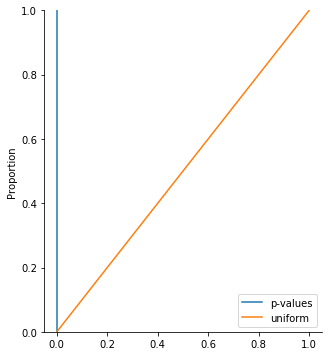

In [63]:
sns.displot(p_values,kind='ecdf',label='p-values')
plt.plot([0,1],[0,1],label='uniform')
plt.legend()
plt.show()

In [64]:
statistics, p_values = ks_test(cc_list_inh_1, cc_list_inh_2)
s = num_fail_pass(statistics, p_values)
print(s)

0 tests passed, 100 tests failed.


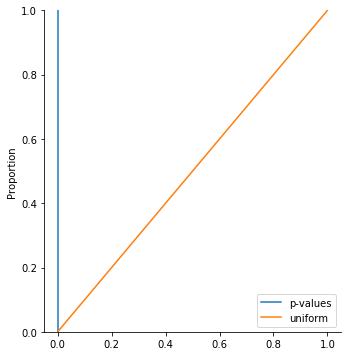

In [65]:
sns.displot(p_values,kind='ecdf',label='p-values')
plt.plot([0,1],[0,1],label='uniform')
plt.legend()
plt.show()

### Exact brunel [1.0, 2.0] vs. exat brunel [0.9375, 2.0625]

Get the data of the second model.

In [66]:
exc_2, inh_2 = exact_equal()
cc_list_exc_2, cc_list_inh_2 = get_cc_lists(exc_2, inh_2)

In [67]:
statistics, p_values = ks_test(cc_list_exc_1, cc_list_exc_2)
s = num_fail_pass(statistics, p_values)
print(s)

50 tests passed, 50 tests failed.


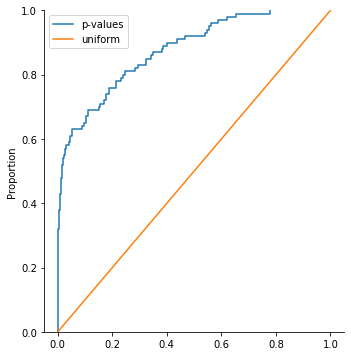

In [68]:
sns.displot(p_values,kind='ecdf',label='p-values')
plt.plot([0,1],[0,1],label='uniform')
plt.legend()
plt.show()

In [69]:
statistics, p_values = ks_test(cc_list_inh_1, cc_list_inh_2)
s = num_fail_pass(statistics, p_values)
print(s)

53 tests passed, 47 tests failed.


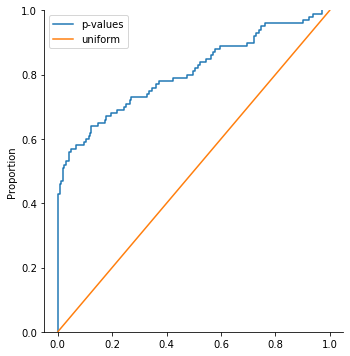

In [70]:
sns.displot(p_values,kind='ecdf',label='p-values')
plt.plot([0,1],[0,1],label='uniform')
plt.legend()
plt.show()

### Exact brunel [1.0, 2.0] vs. continuous brunel on [10, 2.0]
Get the data of second model.

In [71]:
exc_2, inh_2 = continuous()
cc_list_exc_2, cc_list_inh_2 = get_cc_lists(exc_2, inh_2)

In [72]:
statistics, p_values = ks_test(cc_list_exc_1, cc_list_exc_2)
s = num_fail_pass(statistics, p_values)
print(s)

63 tests passed, 37 tests failed.


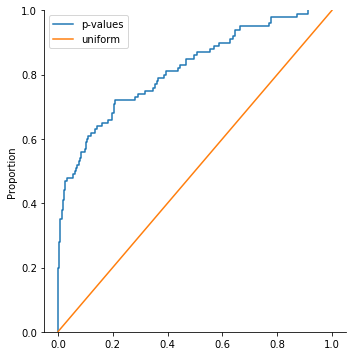

In [73]:
sns.displot(p_values,kind='ecdf',label='p-values')
plt.plot([0,1],[0,1],label='uniform')
plt.legend()
plt.show()

In [74]:
statistics, p_values = ks_test(cc_list_inh_1, cc_list_inh_2)
s = num_fail_pass(statistics, p_values)
print(s)

51 tests passed, 49 tests failed.


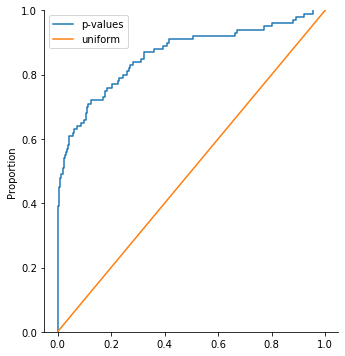

In [75]:
sns.displot(p_values,kind='ecdf',label='p-values')
plt.plot([0,1],[0,1],label='uniform')
plt.legend()
plt.show()

### Rounded brunel on [0.9375, 2.0625] vs. exact brunel on [0.9375, 2.0625]

We now can compare the rounded brunel on [0.93375, 2.0625] against the other models, it is already tested agains the rounded and exact brunel on [1.0,2.0], only test for the two remaining models. Start with exact brunel on same interval.

In [76]:
exc_1, inh_1 = round_equal()
cc_list_exc_1, cc_list_inh_1 = get_cc_lists(exc_1, inh_1)

/usr/local/lib/python3.8/dist-packages/elephant/conversion.py:1168: UserWarning:Binning discarded 1 last spike(s) of the input spiketrain
/usr/local/lib/python3.8/dist-packages/elephant/conversion.py:1168: UserWarning:Binning discarded 2 last spike(s) of the input spiketrain
/usr/local/lib/python3.8/dist-packages/elephant/conversion.py:1168: UserWarning:Binning discarded 3 last spike(s) of the input spiketrain
/usr/local/lib/python3.8/dist-packages/elephant/conversion.py:1168: UserWarning:Binning discarded 4 last spike(s) of the input spiketrain


In [77]:
exc_2, inh_2 = exact_equal()
cc_list_exc_2, cc_list_inh_2 = get_cc_lists(exc_2, inh_2)

In [78]:
statistics, p_values = ks_test(cc_list_exc_1, cc_list_exc_2)
s = num_fail_pass(statistics, p_values)
print(s)

0 tests passed, 100 tests failed.


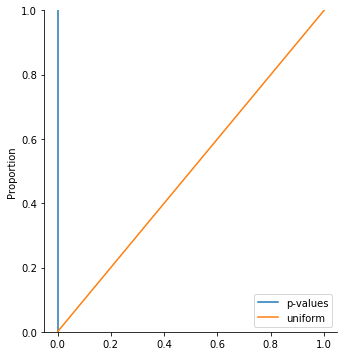

In [79]:
sns.displot(p_values,kind='ecdf',label='p-values')
plt.plot([0,1],[0,1],label='uniform')
plt.legend()
plt.show()

In [80]:
statistics, p_values = ks_test(cc_list_inh_1, cc_list_inh_2)
s = num_fail_pass(statistics, p_values)
print(s)

0 tests passed, 100 tests failed.


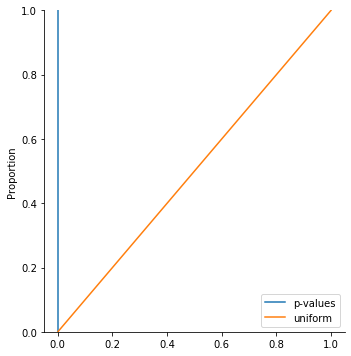

In [81]:
sns.displot(p_values,kind='ecdf',label='p-values')
plt.plot([0,1],[0,1],label='uniform')
plt.legend()
plt.show()

### Rounded brunel on [0.9375, 2.0625] vs. continuous brunel on [1.0, 2.0]

In [82]:
exc_2, inh_2 = continuous()
cc_list_exc_2, cc_list_inh_2 = get_cc_lists(exc_2, inh_2)

In [83]:
statistics, p_values = ks_test(cc_list_exc_1, cc_list_exc_2)
s = num_fail_pass(statistics, p_values)
print(s)

0 tests passed, 100 tests failed.


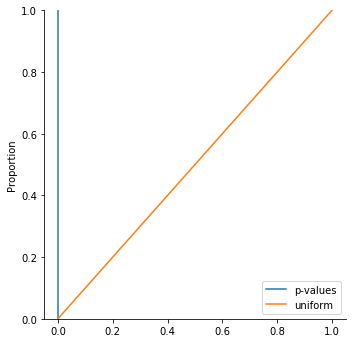

In [84]:
sns.displot(p_values,kind='ecdf',label='p-values')
plt.plot([0,1],[0,1],label='uniform')
plt.legend()
plt.show()

In [85]:
statistics, p_values = ks_test(cc_list_inh_1, cc_list_inh_2)
s = num_fail_pass(statistics, p_values)
print(s)

0 tests passed, 100 tests failed.


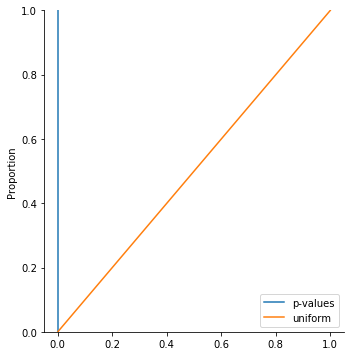

In [86]:
sns.displot(p_values,kind='ecdf',label='p-values')
plt.plot([0,1],[0,1],label='uniform')
plt.legend()
plt.show()

Lastly we have the model with exact spike times on [0.9375, 2.0625], the only model it has not yet been compared to is the continous model, let us compare them here.

### Exact brunel on [0.9375, 2.0625] vs. continuous brunel on [1.0, 2.0]


In [87]:
exc_1, inh_1 = exact_equal()
cc_list_exc_1, cc_list_inh_1 = get_cc_lists(exc_1, inh_1)

In [88]:
exc_2, inh_2 = continuous()
cc_list_exc_2, cc_list_inh_2 = get_cc_lists(exc_2, inh_2)

In [89]:
statistics, p_values = ks_test(cc_list_exc_1, cc_list_exc_2)
s = num_fail_pass(statistics, p_values)
print(s)

54 tests passed, 46 tests failed.


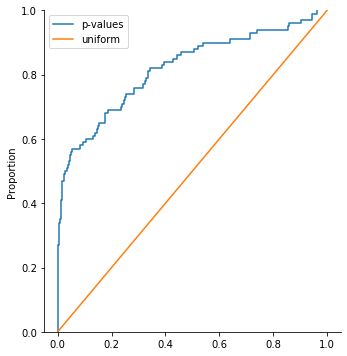

In [90]:
sns.displot(p_values,kind='ecdf',label='p-values')
plt.plot([0,1],[0,1],label='uniform')
plt.legend()
plt.show()

In [91]:
statistics, p_values = ks_test(cc_list_inh_1, cc_list_inh_2)
s = num_fail_pass(statistics, p_values)
print(s)

48 tests passed, 52 tests failed.


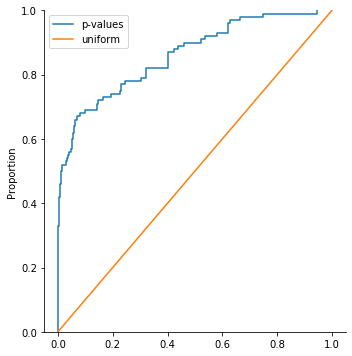

In [92]:
sns.displot(p_values,kind='ecdf',label='p-values')
plt.plot([0,1],[0,1],label='uniform')
plt.legend()
plt.show()